# ALPHA version: FPDS Government Contracts
Analysis of government contract awards for Business Intelligence (BI). 
  
Initial focus on the 541620 NCAIS - Environmental Consulting Services.  
The first dataset was from [this fpds.gov search](https://www.fpds.gov/ezsearch/search.do?q=PRINCIPAL_NAICS_CODE%3A%22541620%22+REF_IDV_PIID%3A%22GS10F0209L%22&s=FPDS.GOV&templateName=1.5.1&indexName=awardfull).  
Ended up not using due to inefficiencies in collecting the data.  
  
However, a better data source was from [the beta.sam.gov site](https://beta.sam.gov).  
This project will clean and analyze this data for a target business in the government contracting arena. Determine competition targets, and gather business intelligence.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import datetime as dt

style.use('fivethirtyeight')
pd.options.display.max_columns = 50


### Initial steps
Report built from beta.sam.gov with specific attributes selected
- Clean up the dataset 
    - deal with null data
    - Fix data types -> numeric, date-time, etc.
    - Determine categorical from text objects.
- EDA to determine applicable metrics
- Create analysis pipeline
- Potentially some feature engineering
- Testing for accuracy of modeled data, rinse and repeat to improve accuracy and quality of reporting.
- Create visualizations to show results




In [2]:
# Read data into dataframe
data2 = pd.read_csv('report1.csv')

In [3]:
data2.head()

,Date Signed,Completion Date,Est. Ultimate Completion Date,Contracting Office Business Size Determination Code,Contracting Office Business Size Determination Description,Funding Agency ID,PIID,Number of Offers Source Code,Number of Offers Received,Award or IDV Type,IDV Number Of Offers,NAICS Code,Vendor Name,Vendor DUNS Number,Cost or Pricing Data,Bundled Contract Code,Contract Financing,Transaction Number,IDV Type Of Contract Pricing,IDV Type Of Contract Pricing Description,Price Evaluation Percent Difference,Base and All Options Value (Total Contract Value),Base and Exercised Options Value,Dollars Obligated,Number of Actions,Number of Records
0,1/1/2020,9/30/2020,9/30/2020,O,OTHER THAN SMALL BUSINESS,12C2,1291S818P0116,F,4.0,PURCHASE ORDER,NaN,541620,"ROBISON ENGINEERING COMPANY, INC",929879831,NaN,H,NaN,0.0,NaN,NaN,NaN,"$2,400.00","$2,400.00","$2,400.00",1,1
1,1/2/2020,8/6/2010,8/6/2010,S,SMALL BUSINESS,7570,HHSP23337002,NaN,0.0,BPA CALL,NaN,541620,"WRUBLE, WAYNE E",601975696,NaN,D,NaN,0.0,J,FIXED PRICE,NaN,$0.00,$0.00,$0.00,1,1
2,1/2/2020,12/31/2016,12/31/2016,O,OTHER THAN SMALL BUSINESS,1330,DOCAB133E14NC0601,F,1.0,DELIVERY ORDER,999.0,541620,"URS GROUP, INC",124645677,NO,D,Z,0.0,J,FIRM FIXED PRICE,NaN,($37.02),($37.02),($37.02),1,1
3,1/2/2020,3/31/2020,3/31/2020,O,OTHER THAN SMALL BUSINESS,6800,68HERH19F0069,F,3.0,DELIVERY ORDER,4.0,541620,"EASTERN RESEARCH GROUP, INC.",112947395,NO,H,NaN,0.0,1,ORDER DEPENDENT (IDV ALLOWS PRICING ARRANGEMEN...,NaN,"$11,584.00","$11,584.00","$11,584.00",1,1
4,1/2/2020,5/30/2020,5/30/2020,O,OTHER THAN SMALL BUSINESS,6800,0005,B,NaN,DELIVERY ORDER,1.0,541620,RESEARCH TRIANGLE INSTITUTE,4868105,NO,D,NaN,0.0,Y,TIME AND MATERIALS,NaN,"$18,624.00","$18,624.00","$18,624.00",1,1


In [4]:
# Converting columns with less than 10 unique values to categorical dtype
for col in data2.columns:
    if len(data2[col].value_counts()) < 10:
        data2[col] = data2[col].fillna('Unknown')
        data2[col] = data2[col].astype('category')

In [5]:
# The data surrounding offers is missing some values
print('Missing values:')
for col in data2.columns:
    if 'Offer' in col:
        print(col + ':', data2[col].isnull().sum())

Missing values:
Number of Offers Source Code: 0
Number of Offers Received: 3693
IDV Number Of Offers: 6414


In [6]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14583 entries, 0 to 14582
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   Date Signed                                                 14583 non-null  object  
 1   Completion Date                                             11091 non-null  object  
 2   Est. Ultimate Completion Date                               11091 non-null  object  
 3   Contracting Office Business Size Determination Code         14583 non-null  category
 4   Contracting Office Business Size Determination Description  14583 non-null  category
 5   Funding Agency ID                                           14583 non-null  object  
 6   PIID                                                        14583 non-null  object  
 7   Number of Offers Source Code                                14583 non-null  

## Resolve dtypes
Functions below fix some of the data types.

In [7]:
def fix_dollars(df):
    '''
    Removes the '$' and ',' and converts to float dtype.
    '''
    fix_cols = []
    for i in df.columns:
        if '$' in str(df[i][0]):
            fix_cols.append(i)
    for col in fix_cols:
        df[col] = df[col].str.replace(
            '$', '', regex=False).str.replace(
            ',', '', regex=False).str.replace(
            '(', '-', regex=False).str.replace(
            ')', '', regex=False)
        df[col] = df[col].astype(float)
    return df

def fix_dates(df):
    '''
    Converts dates from string dtype to datetime
    '''
    for col in df.columns:
        if 'Date' in col:
            df[col] = pd.to_datetime(df[col])
    return df

def remove_NAICS(df):
    '''
    Removes NAICS from df as there currently is only one code, and it is just in the way...
    '''
    if 'NAICS Code' not in df.columns:
        return df
    elif len(df['NAICS Code'].unique()) == 1:
        df = df.drop(columns='NAICS Code')
    return df

def remove_nulls(df, axis=1):
    '''
    Removes columns with 0.25 of total values being null values.
    '''
    df = df.dropna(thresh=df.shape[0]*.25, axis=1)
    return df

def isolate_award_type(df, award_type):
    '''
    Selects only the specified award or IDV type.
    '''
    if isinstance(award_type, list):
        df = df[df['Award or IDV Type'].str.contains('|'.join(award_type), case=False)].copy()
    else:
        df = df[df['Award or IDV Type'] == award_type].copy()
    return df

# For future use:
def create_dummies(df):
    '''
    Create Dummy Columns (One Hot Encoding) from a single Column
    Based on category dtype
    Not currently used, but for ML models in the future.
    '''
    for col in df.select_dtypes(include=['category']).columns:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=col)
    return df

#### Run the functions above on the dataframe

In [8]:
award_types = 'DELIVERY ORDER'

data2 = fix_dollars(data2)
data2 = fix_dates(data2)
data2 = remove_NAICS(data2)
data2 = remove_nulls(data2)

full_data = data2.copy()

data2 = isolate_award_type(data2, award_types)

# data_cats = create_dummies(data2)

In [9]:
# Dataframe info post cleaning
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14583 entries, 0 to 14582
Data columns (total 25 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Date Signed                                                 14583 non-null  datetime64[ns]
 1   Completion Date                                             11091 non-null  datetime64[ns]
 2   Est. Ultimate Completion Date                               11091 non-null  datetime64[ns]
 3   Contracting Office Business Size Determination Code         14583 non-null  category      
 4   Contracting Office Business Size Determination Description  14583 non-null  category      
 5   Funding Agency ID                                           14583 non-null  object        
 6   PIID                                                        14583 non-null  object        
 7   Number of Offers Sourc

In [10]:
import random
colors = [
    "#001427", "#001B2C", "#012232", "#012937", "#01303C", "#023742",
    "#023F47", "#03464D", "#034D52", "#035457", "#045B5D", "#046262"]

c_pal2 = colors[::-1]
c_pal2.pop()

c_pal_blue = c_pal2 + colors
c_pal_shuffle = c_pal_blue
random.shuffle(c_pal_shuffle)

def plotter(data, x_col, y_col, title, *args, **kwargs):
    fig, ax = plt.subplots(figsize=(15,8), facecolor=('gray'))

    x_data = data[x_col]
    y_data = data[y_col]

    ax.tick_params(axis='x', which='major', labelsize=15, labelbottom='off')
    ax.set_yticks([])

    ax.set_facecolor('gray')

    plt.barh(x_data, y_data, data=data, color=c_pal_shuffle, label=x_data)

    for k,v in ax.spines.items():
        ax.spines[k].set_visible(False)

    # Name labels for bars
    name_labels = x_data.to_list()
    for i, name in enumerate(name_labels):
        plt.text(i+1, i, ' ' + name, color='white')

    plt.xlabel(f'{y_col}')
    plt.title(f'{title}', loc='left')
    return plt

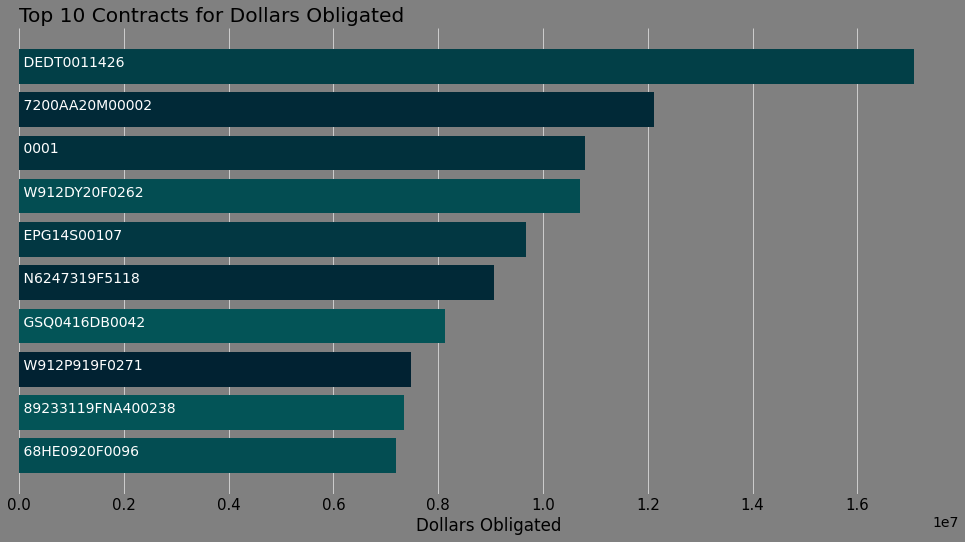

In [11]:
vendor_group = data2.pivot_table(
    index=['PIID'],
    values=['Base and All Options Value (Total Contract Value)',
            'Base and Exercised Options Value',
            'Dollars Obligated',
            'Number of Offers Received'], aggfunc=lambda x: sum(x))
contract_values = vendor_group.sort_values(['Dollars Obligated'], ascending=True).tail(10)

# Not that the PIID's are highly practical, but this is the info readily available
c_vals = contract_values.reset_index()
xtest = plotter(c_vals, 'PIID', 'Dollars Obligated', 'Top 10 Contracts for Dollars Obligated')
xtest.show()

#### Top contracts (for Delivery Order award types)
Above are the the top contracts awarded.  
Below are the vendors involved with those contracts.

In [12]:
# List of vendors on the top contracts above
top_doblig = contract_values.index
vendor_list = {}
for d in top_doblig:
    x = data2[data2['PIID'] == d]
    for i in x['Vendor Name']:
        if d not in vendor_list:
            vendor_list[d] = [i]
        elif i in vendor_list[d]:
            pass
        else:
            vendor_list[d].append(i)

for k, v in vendor_list.items():
    print('PIID: ' + k + ' -')
    for i in v:
        print('-', i)
    print('-'*10)

PIID: 68HE0920F0096 -
- WESTON SOLUTIONS, INC.
----------
PIID: 89233119FNA400238 -
- PROJECT ENHANCEMENT CORPORATION
----------
PIID: W912P919F0271 -
- ARDL, INC.
----------
PIID: GSQ0416DB0042 -
- VERSAR, INC
----------
PIID: N6247319F5118 -
- MANTECH-AECOM JOINT VENTURE
----------
PIID: EPG14S00107 -
- SKEO SOLUTIONS , INC.
----------
PIID: W912DY20F0262 -
- VERSAR, INC.
----------
PIID: 0001 -
- EASTERN RESEARCH GROUP, INC.
- ENVIRONMENTAL MANAGEMENT SUPPORT INC
- BOWHEAD LOGISTICS SOLUTIONS, LLC
- WESTON SOLUTIONS, INC.
- AARCHER INC
- RURAL AND TRIBAL ENVIRONMENTAL SOLUTIONS
- AMEC ENVIRONMENT & INFRASTRUCTURE, INC.
- SRC, INC.
- ENVIRONMENTAL RESEARCH GROUP LLC
- ABT ASSOCIATES INC.
- JV ITAM VIII
- ARS ALEUT REMEDIATION LLC
- WESTON SOLUTIONS, INC
- RURAL COMMUNITY ASSISTANCE CORPORATION
- ICF INCORPORATED, L.L.C.
- SRA INTERNATIONAL, INC.
- ADASPHERE INCORPORATED
- TOEROEK ASSOCIATES, INC.
- RMC CONSULTANTS, INC.
- TETRA TECH, INC.
- ECO & ASSOCIATES INC
- CDM/CSS-DYNAMAC JV
-

In [13]:
full_data['Award or IDV Type'].value_counts()

DELIVERY ORDER         6336
FSS                    2335
BPA CALL               2122
PURCHASE ORDER         1589
DEFINITIVE CONTRACT    1044
IDC                     858
BPA                     298
GWAC                      1
Name: Award or IDV Type, dtype: int64

# Competitor Grouping

In [14]:
#############################################
# Competition Identifier for target - class #
#############################################


class AnalyzeTarget:
    '''Object pipeline for analysis of target business
    TODO:
    Options selections :
        Award or IDV Type
        Target company name
        NAICS code (will need additional datasets--limited to 150,000 rows by site)
        
        
    '''
    def __init__(self, target_co_name, df, *args, **kwargs):
        '''
        init AnalyzeTarget
        args :
            target_name : (str)
            df : (pandas.dataframe object)
        returns : None
        '''
        self.name = target_co_name
        self.df = df
        self.isolated_df = self.df[self.df['Vendor Name'] == self.name]
        self.competitor_dict = {}
    
    def award_type_selection(self, award_type, *args, **kwargs):
        '''
        Filter by award selection type default = DELIVERY ORDER
        '''
        
        self.award_type = award_type
        if self.award_type == None:
            self.award_type = 'All award types'
            df = self.df
        elif isinstance(self.award_type, list):
            df = self.df[self.df['Award or IDV Type'].str.contains(
                '|'.join(self.award_type), case=False)].copy()
        else:
            df = self.df[self.df['Award or IDV Type'].str.contains(
                self.award_type, case=False)].copy()
            self.award_type = df['Award or IDV Type'].iloc[0]
        self.df = df
        
    def competitor_grouper(self, metric='Dollars Obligated', aggf='sum', competition_range=(10, 3), *args, **kwargs):
        '''
        Identifies competitor factors based on selected features
        args :
            metric : (str or list) column(s) to use for comps
            aggf : (str, list, function) used to aggregate groups
            competition_range : (tuple) range of competition comparisons default = (10, 3)
        returns : (pd.dataframe object)
            
        '''
        self.metric = metric
        self.competition_range = competition_range
        self.make_group = self.df.groupby('Vendor Name').agg(aggf)
        self.competition = self.make_group.sort_values(self.metric, ascending=False)
        self.competition.reset_index(inplace=True)
        
        target_index = self.competition[self.competition['Vendor Name'] == self.name].index[0]
        i_up = target_index - competition_range[0]
        i_dn = target_index + competition_range[1]
        
        self.competitors_group = self.competition.iloc[i_up:i_dn, :].sort_values(self.metric)
        for vendor in self.competitors_group['Vendor Name']:
            if vendor != self.name:
                if vendor not in self.competitor_dict:
                    self.competitor_dict[vendor] = [(self.metric, self.award_type)]
                elif self.metric not in self.competitor_dict[vendor]:
                    self.competitor_dict[vendor].append((self.metric, self.award_type))
        
        return self.competitors_group
    
    def print_freq(self):
        print('Overall List of Competitors' + ' '*20 + 'Metric Used')
        longest_k = max([len(l) for l in self.competitor_dict]) + 1
        for k, v in self.competitor_dict.items():
            for i, w in enumerate(v):
                spacer = ' '*(longest_k - len(k))
                if i == 0:
                    print(k + spacer, w)
                else:
                    print(' '*longest_k, w)
            
    def quick_plot(self, data, *args, **kwargs):
        '''
        Quick plot for checking grouping
        '''
        x_data = data['Vendor Name']
        y_data = data[self.metric]
        
        fig, ax = plt.subplots(figsize=(15,8), facecolor=('gray'))
        
        ax.tick_params(axis='x', which='major', labelsize=15, labelbottom='off')
        ax.set_yticks([])
        ax.set_facecolor('gray')
        
        plt.barh(x_data, y_data, data=data, color=c_pal_shuffle, label=x_data)
        
        for k,v in ax.spines.items():
            ax.spines[k].set_visible(False)
            
        # Name labels for bars
        name_labels = x_data.to_list()
        for i, name in enumerate(name_labels):
            plt.text(i+1, i, ' ' + name, color='white')
     
        plt.xlabel(f'{self.metric}')
        plt.title(f'{self.name}\'s Competitor Group\nfor {self.metric.upper()}\nAward Type={self.award_type.upper()}', loc='left')
        
        # Lines to highlight target company
        plt.axhline(self.competition_range[1]/2, color='orange')
        plt.axhline(self.competition_range[1]/2 + 1, color='orange')
        plt.show()
        
    def full_plot(self, data, *args, **kwargs):
        '''
        Full graph display
        '''
        fig, ax = plt.subplots(figsize=(12,8))
        x_data = data[x]

target = 'TOEROEK ASSOCIATES, INC.'

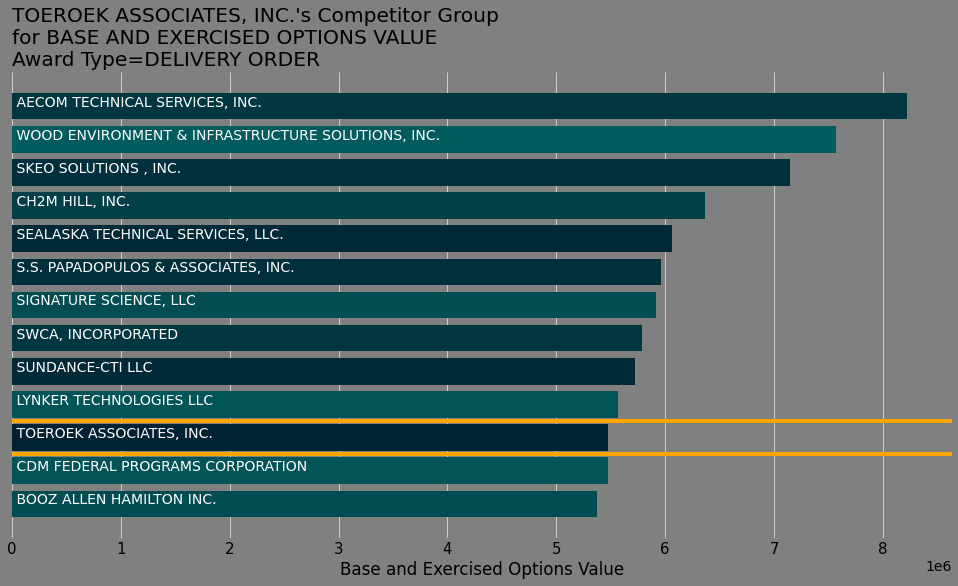

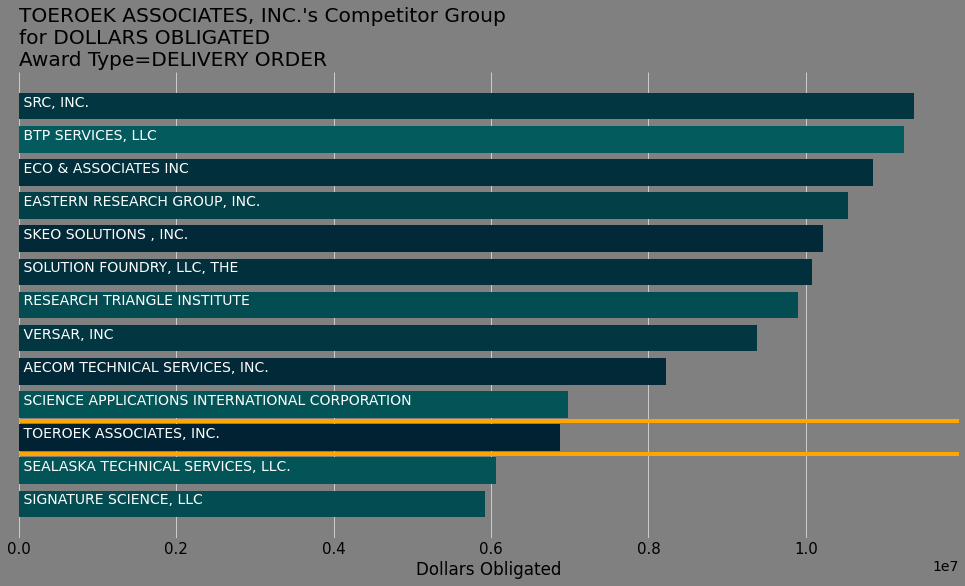

In [15]:
t = AnalyzeTarget(target, full_data)
t.award_type_selection('deliv')
t_grp = t.competitor_grouper(metric='Base and Exercised Options Value')

t.quick_plot(t_grp)
t_grp2 = t.competitor_grouper(metric='Dollars Obligated')
t.quick_plot(t_grp2)
# t.print_freq()

DATA FOR ALL AWARD TYPES


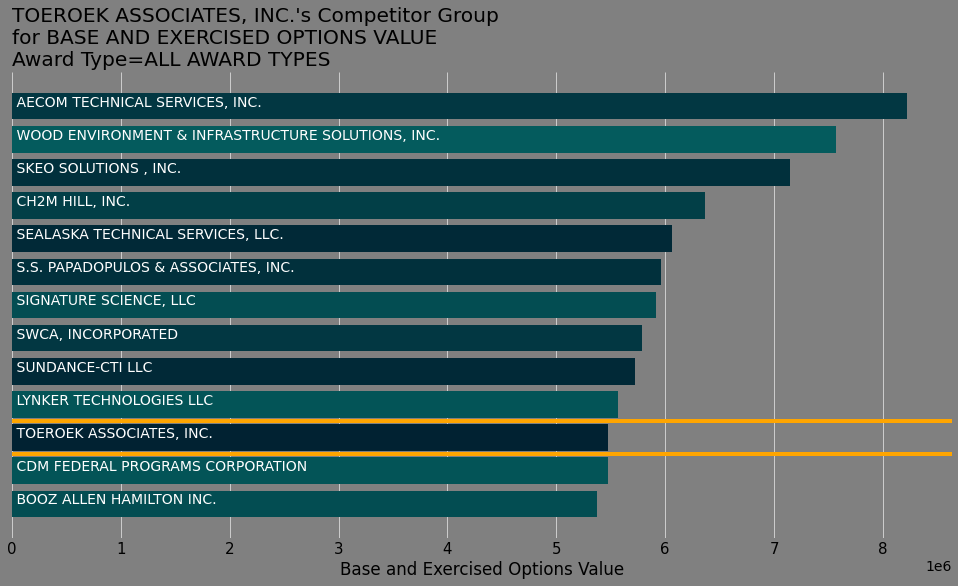

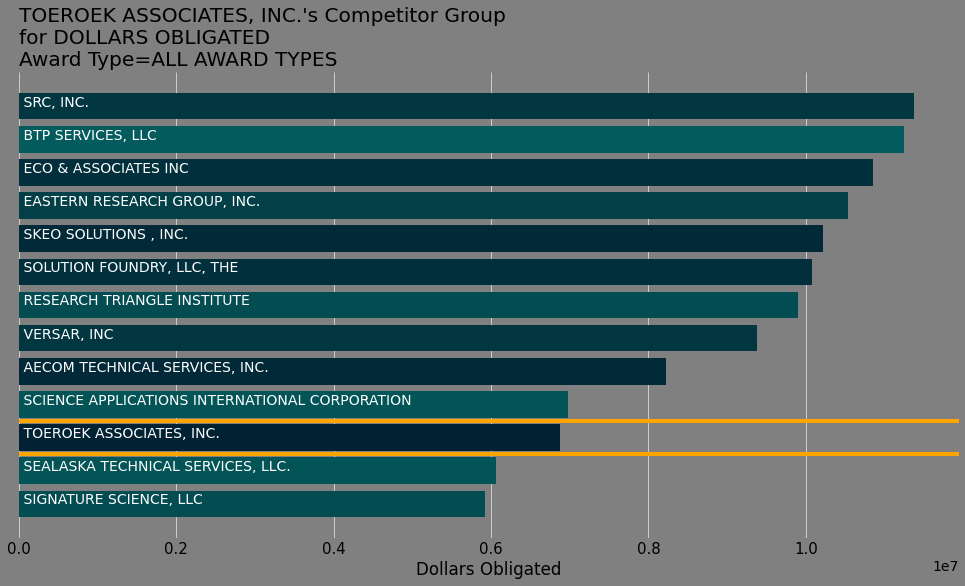

In [16]:
a = AnalyzeTarget(target, full_data)
t.award_type_selection(None)
t_grp = t.competitor_grouper(metric='Base and Exercised Options Value')

print('DATA FOR ALL AWARD TYPES')
t.quick_plot(t_grp)
t_grp2 = t.competitor_grouper(metric='Dollars Obligated')

t.quick_plot(t_grp2)
# t.print_freq()

In [17]:
t.df

,Date Signed,Completion Date,Est. Ultimate Completion Date,Contracting Office Business Size Determination Code,Contracting Office Business Size Determination Description,Funding Agency ID,PIID,Number of Offers Source Code,Number of Offers Received,Award or IDV Type,IDV Number Of Offers,Vendor Name,Vendor DUNS Number,Cost or Pricing Data,Bundled Contract Code,Contract Financing,Transaction Number,IDV Type Of Contract Pricing,IDV Type Of Contract Pricing Description,Price Evaluation Percent Difference,Base and All Options Value (Total Contract Value),Base and Exercised Options Value,Dollars Obligated,Number of Actions,Number of Records
2,2020-01-02,2016-12-31,2016-12-31,O,OTHER THAN SMALL BUSINESS,1330,DOCAB133E14NC0601,F,1.0,DELIVERY ORDER,999.0,"URS GROUP, INC",124645677,NO,D,Z,0.0,J,FIRM FIXED PRICE,Unknown,-37.02,-37.02,-37.02,1,1
3,2020-01-02,2020-03-31,2020-03-31,O,OTHER THAN SMALL BUSINESS,6800,68HERH19F0069,F,3.0,DELIVERY ORDER,4.0,"EASTERN RESEARCH GROUP, INC.",112947395,NO,H,Unknown,0.0,1,ORDER DEPENDENT (IDV ALLOWS PRICING ARRANGEMEN...,Unknown,11584.00,11584.00,11584.00,1,1
4,2020-01-02,2020-05-30,2020-05-30,O,OTHER THAN SMALL BUSINESS,6800,0005,B,NaN,DELIVERY ORDER,1.0,RESEARCH TRIANGLE INSTITUTE,4868105,NO,D,Unknown,0.0,Y,TIME AND MATERIALS,Unknown,18624.00,18624.00,18624.00,1,1
5,2020-01-02,2020-09-30,2020-09-30,S,SMALL BUSINESS,2100,W9115119F0380,B,NaN,DELIVERY ORDER,1.0,"HARRIS ENVIRONMENTAL GROUP, INC.",804640290,NO,H,Z,0.0,J,FIRM FIXED PRICE,Unknown,0.00,0.00,116918.86,1,1
6,2020-01-02,2021-01-01,2021-01-01,S,SMALL BUSINESS,6800,68HERH20F0101,B,NaN,DELIVERY ORDER,2.0,"NEPTUNE AND COMPANY, INCORPORATED",623278447,NO,H,Unknown,0.0,J,FIRM FIXED PRICE,Unknown,44926.00,44926.00,44926.00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14573,2020-12-31,2021-03-31,2021-03-31,O,OTHER THAN SMALL BUSINESS,6800,W912WJ17F0021,B,NaN,DELIVERY ORDER,2.0,"AECOM TECHNICAL SERVICES, INC.",3184462,NO,H,Z,0.0,J,FIRM FIXED PRICE,Unknown,34740.97,34740.97,34740.97,1,1
14575,2020-12-31,2021-05-18,2023-05-18,O,OTHER THAN SMALL BUSINESS,6800,68HERH20F0282,F,4.0,DELIVERY ORDER,6.0,"EASTERN RESEARCH GROUP, INC.",112947395,YES,H,Unknown,0.0,1,ORDER DEPENDENT (IDV ALLOWS PRICING ARRANGEMEN...,Unknown,0.00,0.00,25000.00,1,1
14576,2020-12-31,2021-07-08,2021-07-08,O,OTHER THAN SMALL BUSINESS,6800,68HERH20F0333,B,NaN,DELIVERY ORDER,1.0,"WOOD ENVIRONMENT & INFRASTRUCTURE SOLUTIONS, INC.",38086125,NOT OBTAINED - WAIVED,H,Z,0.0,Y,TIME AND MATERIALS,Unknown,0.00,0.00,448838.60,1,1
14577,2020-12-31,2021-09-05,2025-09-05,O,OTHER THAN SMALL BUSINESS,6800,68HERH20F0394,F,1.0,DELIVERY ORDER,999.0,"WOOD ENVIRONMENT & INFRASTRUCTURE SOLUTIONS, INC.",38086125,Unknown,H,Unknown,0.0,J,FIRM FIXED PRICE,Unknown,0.00,0.00,50000.00,1,1


----
#### The cells below are some exploration
There aren't any descriptions, and I haven't fully implemented any of the ideas below.

In [18]:
target_test = full_data[full_data['Vendor Name'] == target]
target_test['PIID'].unique().size

117

In [19]:
# Create a table of PIID's with 1 under Vendor's name column if they were named on that PIID's row
def expand_piid_vendors(df):
    temp = {x: [0] * len(df['PIID']) for x in data2['Vendor Name'].unique()}
    for i, name in enumerate(df['Vendor Name']):
        for n in name:
            temp[n][i] = 1
    ret_df = pd.DataFrame(temp)
    ret_df = pd.concat([df, ret_df], axis=1)
    return ret_df

piid_grp = data2.groupby('PIID')['Vendor Name'].agg(lambda x: list(x))
piid_grp = piid_grp.reset_index()

piid_grp['Vendor Cnt'] = piid_grp['Vendor Name'].apply(lambda x: len(x))
piid_grp.sort_values('Vendor Cnt', ascending=False)
vendors_on_contract = expand_piid_vendors(piid_grp)
vendors_collab = vendors_on_contract.drop(columns='Vendor Name')
vendors_collab[vendors_collab.columns[2:]].sum(axis=1)

0       27
1       22
2       22
3       22
4       19
        ..
3351     1
3352     1
3353     1
3354     1
3355     1
Length: 3356, dtype: int64

In [20]:
per_piid = data2.groupby('PIID').sum()

In [21]:
per_piid.sort_values('Number of Offers Received', ascending=False)

,Number of Offers Received,IDV Number Of Offers,Vendor DUNS Number,Base and All Options Value (Total Contract Value),Base and Exercised Options Value,Dollars Obligated
PIID,,,,,,
0001,120.0,330.0,17702493913,5448285.69,12237975.06,10807392.31
0004,63.0,266.0,12510973197,-489882.81,230510.19,-492199.27
0003,61.0,183.0,9850864435,-1105894.83,58365.38,314829.29
0005,52.0,175.0,10311098772,1192036.65,1927271.65,2000122.87
0006,47.0,166.0,6181086395,-76479.81,907489.19,419274.02
...,...,...,...,...,...,...
140L0619F0331,0.0,6.0,110398349,0.00,0.00,0.00
68HE0919F0055,0.0,2.0,825211824,-28730.64,-28730.64,-28730.64
68HE0919F0056,0.0,2.0,825211824,-24482.67,-24482.67,-19909.43


In [22]:
full_data['Award or IDV Type'].value_counts()

DELIVERY ORDER         6336
FSS                    2335
BPA CALL               2122
PURCHASE ORDER         1589
DEFINITIVE CONTRACT    1044
IDC                     858
BPA                     298
GWAC                      1
Name: Award or IDV Type, dtype: int64

In [23]:
vendor_volume = data2.groupby('Vendor Name')['PIID'].nunique().sort_values(ascending=False).head(25)
vendor_volume

Vendor Name
TETRA TECH, INC.                                         254
TOEROEK ASSOCIATES, INC.                                 111
WESTON SOLUTIONS, INC.                                   107
EASTERN RESEARCH GROUP, INC.                              67
ICF INCORPORATED, L.L.C.                                  64
PHIGENICS, LLC                                            46
PALEOWEST LLC                                             41
NATIONAL ACADEMY OF SCIENCES                              40
ENVIRONMENTAL MANAGEMENT AND PLANNING SOLUTIONS, INC.     39
NEPTUNE AND COMPANY, INCORPORATED                         39
INTEGRATED MISSION SUPPORT SERVICES LLC                   39
TRC ENVIRONMENTAL CORPORATION                             36
WOOD ENVIRONMENT & INFRASTRUCTURE SOLUTIONS, INC.         34
BOOZ ALLEN HAMILTON INC.                                  33
JESCO-GSRC JOINT VENTURE                                  33
HSG, LLC                                                  28
CDM FEDERAL 

In [24]:
ytarget = data2[(data2['Vendor Name'] == target) & (data2['Award or IDV Type'] == 'DELIVERY ORDER')]

In [25]:
data2[data2['Vendor Name'].str.contains('TETRA TECH, INC.|TOE')]

,Date Signed,Completion Date,Est. Ultimate Completion Date,Contracting Office Business Size Determination Code,Contracting Office Business Size Determination Description,Funding Agency ID,PIID,Number of Offers Source Code,Number of Offers Received,Award or IDV Type,IDV Number Of Offers,Vendor Name,Vendor DUNS Number,Cost or Pricing Data,Bundled Contract Code,Contract Financing,Transaction Number,IDV Type Of Contract Pricing,IDV Type Of Contract Pricing Description,Price Evaluation Percent Difference,Base and All Options Value (Total Contract Value),Base and Exercised Options Value,Dollars Obligated,Number of Actions,Number of Records
56,2020-01-06,2021-04-30,2021-04-30,S,SMALL BUSINESS,6800,68HE0720F0030,F,2.0,DELIVERY ORDER,3.0,"TOEROEK ASSOCIATES, INC.",825211824,NO,H,Unknown,0.0,Y,TIME AND MATERIALS,Unknown,331517.67,331517.67,331517.67,1,1
128,2020-01-08,2020-06-25,2020-06-25,O,OTHER THAN SMALL BUSINESS,6800,68HE0720F0038,B,NaN,DELIVERY ORDER,2.0,"TETRA TECH, INC.",806586967,YES,H,Unknown,0.0,1,ORDER DEPENDENT (IDV ALLOWS PRICING ARRANGEMEN...,Unknown,18356.63,18356.63,18356.63,1,1
139,2020-01-08,2020-12-31,2024-07-14,O,OTHER THAN SMALL BUSINESS,6800,68HE0419F0097,F,1.0,DELIVERY ORDER,2.0,"TETRA TECH, INC.",21203638,NO,H,Unknown,0.0,Y,TIME AND MATERIALS,Unknown,0.00,0.00,0.00,1,1
205,2020-01-10,2020-10-30,2020-10-30,O,OTHER THAN SMALL BUSINESS,6800,68HE0918F0415,B,NaN,DELIVERY ORDER,3.0,"TETRA TECH, INC.",361267339,YES,H,Unknown,0.0,Y,TIME AND MATERIALS,Unknown,36595.76,36595.76,36595.76,1,1
209,2020-01-10,2021-04-09,2021-04-09,O,OTHER THAN SMALL BUSINESS,6800,68HE0919F0017,B,NaN,DELIVERY ORDER,3.0,"TETRA TECH, INC.",361267339,YES,H,Unknown,0.0,Y,TIME AND MATERIALS,Unknown,71776.54,71776.54,71776.54,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14470,2020-12-22,2024-07-07,2024-07-07,O,OTHER THAN SMALL BUSINESS,6800,68HE0520F0023,F,1.0,DELIVERY ORDER,2.0,"TETRA TECH, INC.",80106449,NO,H,Unknown,0.0,Y,TIME AND MATERIALS,Unknown,0.00,0.00,0.00,1,1
14471,2020-12-22,2024-07-14,2024-07-14,O,OTHER THAN SMALL BUSINESS,6800,68HE0420F0040,F,1.0,DELIVERY ORDER,2.0,"TETRA TECH, INC.",21203638,NO,H,Unknown,0.0,Y,TIME AND MATERIALS,Unknown,0.00,0.00,330000.00,1,1
14490,2020-12-23,2021-09-21,2021-09-21,O,OTHER THAN SMALL BUSINESS,6800,68HERC21F0044,B,NaN,DELIVERY ORDER,2.0,"TETRA TECH, INC.",198549560,NO,H,Unknown,0.0,Y,TIME AND MATERIALS,Unknown,0.00,18570.00,18570.00,1,1
14532,2020-12-29,2020-11-23,2021-01-03,S,SMALL BUSINESS,6800,0029,F,2.0,DELIVERY ORDER,2.0,"TOEROEK ASSOCIATES, INC.",825211824,NO,D,Unknown,0.0,1,ORDER DEPENDENT (IDV ALLOWS PRICING ARRANGEMEN...,Unknown,-3536.02,-3536.02,0.00,1,1


In [26]:
ygrp = ytarget.groupby('Date Signed').sum()
ygrp = ygrp.agg('cumsum')
ygrp.reset_index(inplace=True)



Text(0.5, 1.0, 'Dollars Obligated\nfor TOEROEK ASSOCIATES, INC.\n(Cumulative in Millions)')

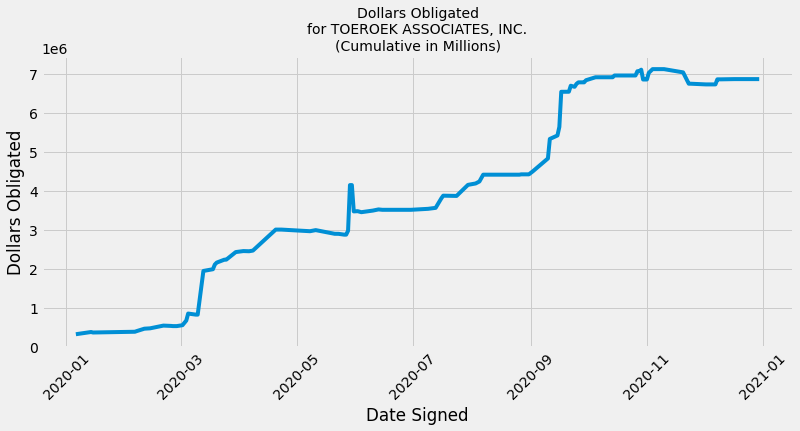

In [27]:
#plt.plot('Date Signed', 'Dollars Obligated', data=ygrp)
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(x='Date Signed', y='Dollars Obligated', data=ygrp)
plt.xticks(rotation=45)
plt.title(f'Dollars Obligated\nfor {target}\n(Cumulative in Millions)', fontsize=14)

In [28]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6336 entries, 2 to 14579
Data columns (total 25 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Date Signed                                                 6336 non-null   datetime64[ns]
 1   Completion Date                                             6336 non-null   datetime64[ns]
 2   Est. Ultimate Completion Date                               6336 non-null   datetime64[ns]
 3   Contracting Office Business Size Determination Code         6336 non-null   category      
 4   Contracting Office Business Size Determination Description  6336 non-null   category      
 5   Funding Agency ID                                           6336 non-null   object        
 6   PIID                                                        6336 non-null   object        
 7   Number of Offers Source

In [29]:

data2.corr()

,Number of Offers Received,IDV Number Of Offers,Vendor DUNS Number,Base and All Options Value (Total Contract Value),Base and Exercised Options Value,Dollars Obligated
Number of Offers Received,1.000000,0.052126,0.039626,0.020599,0.021323,-0.005040
IDV Number Of Offers,0.052126,1.000000,0.082295,0.022024,0.022986,0.020384
Vendor DUNS Number,0.039626,0.082295,1.000000,-0.009796,-0.004695,-0.036174
Base and All Options Value (Total Contract Value),0.020599,0.022024,-0.009796,1.000000,0.828026,0.368696
Base and Exercised Options Value,0.021323,0.022986,-0.004695,0.828026,1.000000,0.394323
Dollars Obligated,-0.005040,0.020384,-0.036174,0.368696,0.394323,1.000000


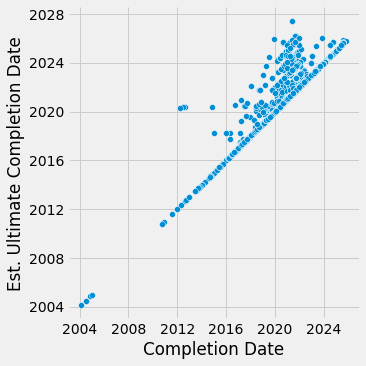

In [30]:
sns.relplot(x='Completion Date', y='Est. Ultimate Completion Date', data=data2)

In [ ]:
not_equal_dates = data2[data2['Completion Date'] != data2['Est. Ultimate Completion Date']]
sns.relplot(x='Completion Date', y='Est. Ultimate Completion Date', data=not_equal_dates)

In [ ]:
not_equal_dates

In [ ]:
sns.relplot(x='Base and Exercised Options Value', y='Dollars Obligated', hue='Number of Offers Received', data=data2[data2['Vendor Name'] == target])


In [ ]:
data2['Number of Offers Source Code'].value_counts()

In [ ]:
data2

In [ ]:
data2.groupby('PIID')['Dollars Obligated'].sum()